# Some Siri-ous Music Shuffler

In [125]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import spotipy
import time
import pandas as pd
import random
import requests
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials 

## 0. Load csv file created via "Librosa.ipnyb"

In [129]:
librosa_ex = pd.read_csv('librosa.csv')
librosa_ex

,Unnamed: 0,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
0,0,"['1991____________', '']",ballad thirsty,0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375
1,1,['ASAP'],idol day isn't it,0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219
2,2,['AUTOMATIC'],chaser please,0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014
3,3,"['Acrobat___', '']",chaser please,0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909
4,4,"['All_I_Want_for_Christmas_Is', 'You']",pop-sick-cl,0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,"['________op', '15-4']",chaser please,0.246907,771.958456,853.939360,1238.936533,0.085947,0.048051,0.190438,32.648077,26.074310,107.666016
96,96,['abcdefu'],wanna grainger & chiil?,0.328493,2392.442293,2493.352857,4978.619895,0.192195,0.108614,0.207177,25.143848,27.049334,123.046875
97,97,['oui'],ballad thirsty,0.386327,2751.472653,2606.757557,5736.186147,0.245609,0.131242,0.227551,23.975494,25.985123,117.453835
98,98,"['pushin_P__feat__Young_Thug', '']",chaser please,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081


In [130]:
librosa_ex = librosa_ex.iloc[: , 1:]
names = librosa_ex[['song', 'playlist']]
features = librosa_ex[['chroma_stft',
                'spectral_centroid',
                'spectral_bandwidth',
                'spectral_rolloff',
                'rms',
                'zero_crossing_rate',
                'chroma_cens',
                'spectral_contrast',
                'feature.mfcc',
                'tempo']]

In [131]:
names

,song,playlist
0,"['1991____________', '']",ballad thirsty
1,['ASAP'],idol day isn't it
2,['AUTOMATIC'],chaser please
3,"['Acrobat___', '']",chaser please
4,"['All_I_Want_for_Christmas_Is', 'You']",pop-sick-cl
...,...,...
95,"['________op', '15-4']",chaser please
96,['abcdefu'],wanna grainger & chiil?
97,['oui'],ballad thirsty
98,"['pushin_P__feat__Young_Thug', '']",chaser please


## 1. Scale

In [132]:
features

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
0,0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375
1,0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219
2,0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014
3,0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909
4,0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688
...,...,...,...,...,...,...,...,...,...,...
95,0.246907,771.958456,853.939360,1238.936533,0.085947,0.048051,0.190438,32.648077,26.074310,107.666016
96,0.328493,2392.442293,2493.352857,4978.619895,0.192195,0.108614,0.207177,25.143848,27.049334,123.046875
97,0.386327,2751.472653,2606.757557,5736.186147,0.245609,0.131242,0.227551,23.975494,25.985123,117.453835
98,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081


### 1.1 MinMax Scaler [Normalize]

In [133]:
scaler1 = MinMaxScaler()
scaled1 = scaler1.fit_transform(features)

### 1.2 Standard Scaler [Standardize]

In [134]:
scaler2 = StandardScaler()
scaled2 = scaler2.fit_transform(features)

## 2. Elbow Method

### 2.1 Minmax

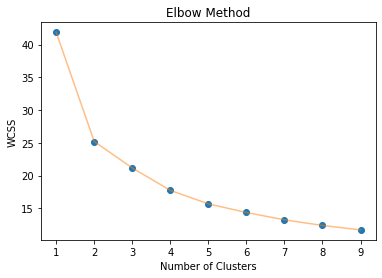

In [135]:
wcss = []
for i in range(1,10):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(scaled1)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, 'o')
plt.plot(range(1 , 10) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 2.2 Standard

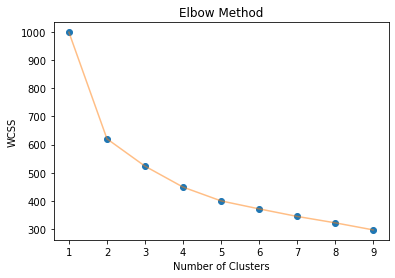

In [136]:
wcss = []
for i in range(1,10):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(scaled2)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss, 'o')
plt.plot(range(1 , 10) , wcss , '-' , alpha = 0.5)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## 3. Silhouette Score

### 3.1 Minmax

In [137]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(scaled1)
    preds = km.predict(scaled1) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(scaled1, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.4028775649634076
Number of Clusters = 3, Silhouette Score = 0.24822783182721964
Number of Clusters = 4, Silhouette Score = 0.21762981350432994
Number of Clusters = 5, Silhouette Score = 0.2063961333469791
Number of Clusters = 6, Silhouette Score = 0.21022188296772157
Number of Clusters = 7, Silhouette Score = 0.2232742038167112
Number of Clusters = 8, Silhouette Score = 0.22506973998156055
Number of Clusters = 9, Silhouette Score = 0.19852720935653523
Number of Clusters = 10, Silhouette Score = 0.21076819768135266
Number of Clusters = 11, Silhouette Score = 0.1904665913917634
Number of Clusters = 12, Silhouette Score = 0.1924653087197365
Number of Clusters = 13, Silhouette Score = 0.1988495941672909
Number of Clusters = 14, Silhouette Score = 0.1931067382134033
Number of Clusters = 15, Silhouette Score = 0.2068518219002432
Number of Clusters = 16, Silhouette Score = 0.21086590774361708
Number of Clusters = 17, Silhouette Score = 0.1939778110

### 3.2 Standard

In [138]:
n_clusters = range(2,21)
ssd = []
sc = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(scaled2)
    preds = km.predict(scaled2) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(scaled2, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.3817614998252639
Number of Clusters = 3, Silhouette Score = 0.19598784476118958
Number of Clusters = 4, Silhouette Score = 0.21042645973954455
Number of Clusters = 5, Silhouette Score = 0.19140305176915032
Number of Clusters = 6, Silhouette Score = 0.1883986922027528
Number of Clusters = 7, Silhouette Score = 0.20280769796434964
Number of Clusters = 8, Silhouette Score = 0.18776496572956047
Number of Clusters = 9, Silhouette Score = 0.18741354720168213
Number of Clusters = 10, Silhouette Score = 0.2011827861242666
Number of Clusters = 11, Silhouette Score = 0.19148699481935935
Number of Clusters = 12, Silhouette Score = 0.17590277675504012
Number of Clusters = 13, Silhouette Score = 0.20012058961879464
Number of Clusters = 14, Silhouette Score = 0.18748701775864052
Number of Clusters = 15, Silhouette Score = 0.1993143470815838
Number of Clusters = 16, Silhouette Score = 0.20110064613684223
Number of Clusters = 17, Silhouette Score = 0.194947

## 4. ML

### 4.1.a Clustering [MinMax]

#### We decided to set 7 as the number of clusters - disregarding results from the previous methods in finding the value for a "k" isn't recommended or valid; however, since our algorithm cannot be accessed by computational scores, we manually and subjectively came up with the number that yielded the most reasonable output.

In [139]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans_lib = kmeans.fit_predict(scaled1)

In [140]:
kmeans_lib = pd.DataFrame(data=y_kmeans_lib, dtype=int)
kmeans_lib.columns = ['k_cluster']
kmeans_lib

,k_cluster
0,3
1,1
2,4
3,1
4,5
...,...
95,2
96,5
97,1
98,6


#### Put it back together

In [141]:
librosa_df = pd.concat([names, features], axis=1)
librosa_df

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
0,"['1991____________', '']",ballad thirsty,0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375
1,['ASAP'],idol day isn't it,0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219
2,['AUTOMATIC'],chaser please,0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014
3,"['Acrobat___', '']",chaser please,0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909
4,"['All_I_Want_for_Christmas_Is', 'You']",pop-sick-cl,0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"['________op', '15-4']",chaser please,0.246907,771.958456,853.939360,1238.936533,0.085947,0.048051,0.190438,32.648077,26.074310,107.666016
96,['abcdefu'],wanna grainger & chiil?,0.328493,2392.442293,2493.352857,4978.619895,0.192195,0.108614,0.207177,25.143848,27.049334,123.046875
97,['oui'],ballad thirsty,0.386327,2751.472653,2606.757557,5736.186147,0.245609,0.131242,0.227551,23.975494,25.985123,117.453835
98,"['pushin_P__feat__Young_Thug', '']",chaser please,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081


In [142]:
librosa_MM = librosa_df.join(kmeans_lib)

In [143]:
group_MM = librosa_MM.groupby('k_cluster')

#### Summary per Group

In [144]:
averages_MM = group_MM.mean()
averages_MM

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
k_cluster,,,,,,,,,,
0,0.356533,2096.380792,2262.208640,4428.826406,0.188122,0.088009,0.208900,25.829613,26.586945,153.603646
1,0.407131,2737.916320,2621.562186,5765.139950,0.227686,0.123632,0.221432,23.322161,26.026734,133.727635
2,0.301847,737.053519,1121.763785,1203.645761,0.086802,0.035355,0.193179,28.004315,25.962403,119.520153
3,0.308045,1542.575714,2008.288866,3174.051343,0.119383,0.058608,0.189327,27.336481,27.922182,98.912362
4,0.392085,2093.147975,2327.868996,4472.415491,0.238271,0.083695,0.224690,24.649185,26.433498,102.982270
5,0.329933,2486.538789,2551.342106,5340.749115,0.147159,0.107429,0.213240,25.579697,27.317713,110.505576
6,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081


In [145]:
# df = pd.DataFrame({'a': [10,20],'b':[100,200],'c': ['a','b']})

# df.loc['Column_Total']= df.sum(numeric_only=True, axis=0)


averages_MM.loc[:,'Row_Total'] = averages_MM.sum(numeric_only=True, axis=1)



In [146]:
averages_MM

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
0,0.356533,2096.380792,2262.208640,4428.826406,0.188122,0.088009,0.208900,25.829613,26.586945,153.603646,8994.277607
1,0.407131,2737.916320,2621.562186,5765.139950,0.227686,0.123632,0.221432,23.322161,26.026734,133.727635,11308.674866
2,0.301847,737.053519,1121.763785,1203.645761,0.086802,0.035355,0.193179,28.004315,25.962403,119.520153,3236.567119
3,0.308045,1542.575714,2008.288866,3174.051343,0.119383,0.058608,0.189327,27.336481,27.922182,98.912362,6879.762311
4,0.392085,2093.147975,2327.868996,4472.415491,0.238271,0.083695,0.224690,24.649185,26.433498,102.982270,9048.436154
5,0.329933,2486.538789,2551.342106,5340.749115,0.147159,0.107429,0.213240,25.579697,27.317713,110.505576,10542.830756
6,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081,9613.407428


In [147]:
averages_MM.loc[[0]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
0,0.356533,2096.380792,2262.20864,4428.826406,0.188122,0.088009,0.2089,25.829613,26.586945,153.603646,8994.277607


In [148]:
group_MM.get_group(0).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
5,['Appear'],ballad thirsty,0.293963,2207.284255,2491.533018,4934.661827,0.229631,0.091151,0.207591,27.111102,26.148813,129.199219,0
11,['Blueberry_Eyes__feat__Lil_Mosey__SUGA_of_BTS...,chaser please,0.376669,2102.900376,2333.128906,4307.253121,0.216347,0.090297,0.238949,23.570359,26.516512,151.999081,0
12,"['Blueberry_Eyes__feat__SUGA_of_BTS', '']",chaser please,0.383315,2132.415838,2452.466986,4807.350097,0.224595,0.079245,0.229844,24.589574,26.514357,151.999081,0
15,['CREDIT'],chaser please,0.359113,2015.410488,2045.368460,3983.438413,0.167716,0.086781,0.190124,27.088206,26.513573,161.499023,0
23,['FRIENDS'],wanna grainger & chiil?,0.329119,2286.010581,2327.802305,4461.752187,0.163275,0.101932,0.214165,25.885531,26.243515,161.499023,0


In [164]:
group_MM.get_group(0)['playlist'].value_counts().idxmax()

'chaser please'

In [149]:
averages_MM.loc[[1]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
1,0.407131,2737.91632,2621.562186,5765.13995,0.227686,0.123632,0.221432,23.322161,26.026734,133.727635,11308.674866


In [150]:
group_MM.get_group(1).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
1,['ASAP'],idol day isn't it,0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219,1
3,"['Acrobat___', '']",chaser please,0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909,1
7,['BOOM'],chaser please,0.526647,2949.645478,2367.788705,5498.125087,0.158051,0.190149,0.247005,20.866089,27.972897,123.046875,1
9,"['Bad', 'Boy']",idol day isn't it,0.319448,2597.659099,2540.039083,5638.936735,0.212148,0.117902,0.212617,24.762389,26.445461,151.999081,1
14,"['Boong-Boong__Prod__by_GroovyRoom', '']",chaser please,0.354960,2578.587684,2561.784305,5548.012285,0.203354,0.109927,0.210514,23.931260,25.536243,135.999178,1


In [163]:
group_MM.get_group(1)['playlist'].value_counts().idxmax()

"idol day isn't it"

In [151]:
averages_MM.loc[[2]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
2,0.301847,737.053519,1121.763785,1203.645761,0.086802,0.035355,0.193179,28.004315,25.962403,119.520153,3236.567119


In [152]:
group_MM.get_group(2).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
6,"['Autumn_in_New', 'York']",jazzy-pact,0.287134,661.930205,1111.479380,1032.389591,0.085839,0.030126,0.186841,28.998428,26.267736,107.666016,2
10,"['Blue', 'Moon']",jazzy-pact,0.322498,608.479298,1094.809423,920.511101,0.097532,0.028521,0.191406,27.705401,25.835968,117.453835,2
46,"['Make_Me', 'Rainbows']",jazzy-pact,0.362804,967.686955,1690.989140,1798.726623,0.069397,0.026805,0.199427,25.519110,26.423944,107.666016,2
63,"['Regent_s', 'Park']",wanna grainger & chiil?,0.323171,973.677270,1386.411235,1831.959756,0.170799,0.037777,0.196811,25.649360,26.471655,129.199219,2
72,"['Skating_In_Central', 'Park']",jazzy-pact,0.232954,644.940077,1016.819973,840.811582,0.050012,0.040633,0.187140,26.245924,25.326738,129.199219,2


In [165]:
group_MM.get_group(2)['playlist'].value_counts().idxmax()

'jazzy-pact'

In [153]:
averages_MM.loc[[3]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
3,0.308045,1542.575714,2008.288866,3174.051343,0.119383,0.058608,0.189327,27.336481,27.922182,98.912362,6879.762311


In [154]:
group_MM.get_group(3).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
0,"['1991____________', '']",ballad thirsty,0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375,3
17,"['Can_I_Love____feat__youra__Meego', '']",chaser please,0.316272,1381.886737,1719.168721,2557.726200,0.209775,0.057007,0.196181,26.206671,26.934220,80.749512,3
21,['Easy'],wanna grainger & chiil?,0.419281,1225.363550,1630.064616,2383.823085,0.108500,0.054407,0.202825,25.764245,27.520882,46.142578,3
22,"['Every_moment_of_you________', '']",ballad thirsty,0.252587,1809.273797,2256.353417,3882.276524,0.128746,0.067707,0.182971,27.618789,28.086800,135.999178,3
36,['Just'],wanna grainger & chiil?,0.340617,1864.695581,2115.102977,3676.786100,0.055391,0.093589,0.205061,25.588665,29.000528,86.132812,3


In [166]:
group_MM.get_group(3)['playlist'].value_counts().idxmax()

'ballad thirsty'

In [155]:
averages_MM.loc[[4]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
4,0.392085,2093.147975,2327.868996,4472.415491,0.238271,0.083695,0.22469,24.649185,26.433498,102.98227,9048.436154


In [156]:
group_MM.get_group(4).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
2,['AUTOMATIC'],chaser please,0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014,4
13,"['Bon_voyage__feat_Beenzino', '']",wanna grainger & chiil?,0.427799,1769.541419,2215.633436,3896.630604,0.244574,0.066941,0.235601,24.588222,27.188017,89.102909,4
19,['Dynamite'],idol day isn't it,0.378362,2389.092372,2545.961029,5193.251930,0.263375,0.094098,0.245055,24.817800,26.285482,112.347147,4
34,"['Jam__', 'Butterfly']",chaser please,0.446222,1932.918519,2230.561239,4078.071174,0.243410,0.073298,0.238078,22.895126,26.663528,151.999081,4
35,['Johnny'],chaser please,0.374517,1986.597325,2278.872771,4234.103564,0.198234,0.078675,0.210875,25.075829,26.472515,99.384014,4


In [167]:
group_MM.get_group(4)['playlist'].value_counts().idxmax()

'chaser please'

In [157]:
averages_MM.loc[[5]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
5,0.329933,2486.538789,2551.342106,5340.749115,0.147159,0.107429,0.21324,25.579697,27.317713,110.505576,10542.830756


In [158]:
group_MM.get_group(5).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
4,"['All_I_Want_for_Christmas_Is', 'You']",pop-sick-cl,0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688,5
8,['Bad'],pop-sick-cl,0.332162,2587.161704,2523.226791,5345.530176,0.156738,0.113807,0.219621,24.994385,27.081507,95.703125,5
16,"['C', 'line']",wanna grainger & chiil?,0.285586,2554.880432,2529.460997,5515.820813,0.148467,0.105622,0.207804,25.887534,26.905827,117.453835,5
18,"['Counting', 'Stars']",wanna grainger & chiil?,0.398034,2935.740497,2554.618536,5649.211673,0.078685,0.154757,0.226662,24.206458,27.447937,117.453835,5
26,['Gentleman'],jazzy-pact,0.318367,2414.617269,2673.296946,5540.833162,0.041937,0.094227,0.231850,24.241085,27.880200,99.384014,5


In [168]:
group_MM.get_group(5)['playlist'].value_counts().idxmax()

'wanna grainger & chiil?'

In [159]:
averages_MM.loc[[6]]

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,Row_Total
k_cluster,,,,,,,,,,,
6,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081,9613.407428


In [160]:
group_MM.get_group(6).head()

,song,playlist,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
98,"['pushin_P__feat__Young_Thug', '']",chaser please,0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081,6


In [170]:
group_MM.get_group(6)['playlist'].value_counts().idxmax()

'chaser please'

In [124]:
print("What you want?: ")

x = int(input())
y = librosa_MM.iloc[x]['k_cluster']

print("Your pick is: " + names.iat[x,0])
print(librosa_MM[librosa_MM['k_cluster']==y]['song'])
print(group_MM.get_group(1)['playlist'].value_counts().idxmax())

What you want?: 
48
Your pick is: ['Martini', 'Blue']
5                                            ['Appear']
11    ['Blueberry_Eyes__feat__Lil_Mosey__SUGA_of_BTS...
12            ['Blueberry_Eyes__feat__SUGA_of_BTS', '']
15                                           ['CREDIT']
23                                          ['FRIENDS']
24                           ['GANADARA__Feat__IU', '']
29                        ['Heartbreak', 'Anniversary']
43                                  ['Love', 'Blossom']
48                                  ['Martini', 'Blue']
55                                  ['ON_IT___BO_', '']
57                       ['PARADISE__Feat__meenoi', '']
66                                    ['SICKO', 'MODE']
68                     ['STAY__with_Justin_Bieber', '']
71                               ['Selfmade', 'Orange']
81                               ['Stay_At_Our', 'Sea']
87                                  ['Toosie', 'Slide']
93                                           ['__'

### 4.1.b Clustering [Standard]

In [34]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans_lib = kmeans.fit_predict(scaled2)

In [35]:
kmeans_lib = pd.DataFrame(data=y_kmeans_lib, dtype=int)
kmeans_lib.columns = ['k_cluster']
kmeans_lib

,k_cluster
0,2
1,3
2,1
3,5
4,0
...,...
95,4
96,0
97,3
98,5


#### Put it back together

In [36]:
librosa_df = pd.concat([names, features], axis=1)
librosa_df

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
0,"['1991____________', '']",0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375
1,['ASAP'],0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219
2,['AUTOMATIC'],0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014
3,"['Acrobat___', '']",0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909
4,"['All_I_Want_for_Christmas_Is', 'You']",0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688
...,...,...,...,...,...,...,...,...,...,...,...
95,"['________op', '15-4']",0.246907,771.958456,853.939360,1238.936533,0.085947,0.048051,0.190438,32.648077,26.074310,107.666016
96,['abcdefu'],0.328493,2392.442293,2493.352857,4978.619895,0.192195,0.108614,0.207177,25.143848,27.049334,123.046875
97,['oui'],0.386327,2751.472653,2606.757557,5736.186147,0.245609,0.131242,0.227551,23.975494,25.985123,117.453835
98,"['pushin_P__feat__Young_Thug', '']",0.600536,2006.681289,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081


In [37]:
librosa_ST = librosa_df.join(kmeans_lib)

In [38]:
group_ST = librosa_ST.groupby('k_cluster')

#### Summary per Group

In [39]:
averages_ST = group_ST.mean()
averages_ST

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
k_cluster,,,,,,,,,,
0,0.316773,2390.934021,2516.459237,5177.129301,0.146467,0.100484,0.210204,25.961629,27.360947,110.601416
1,0.385789,2086.669098,2313.876606,4429.323911,0.239240,0.085092,0.225344,24.495318,26.524298,107.136301
2,0.309188,1548.068554,2012.129251,3186.144015,0.125486,0.059263,0.190211,27.247299,27.805888,105.614173
3,0.394153,2821.143864,2604.762989,5788.169166,0.195157,0.140765,0.228414,23.522491,26.621915,111.688171
4,0.301847,737.053519,1121.763785,1203.645761,0.086802,0.035355,0.193179,28.004315,25.962403,119.520153
5,0.467961,2649.714696,2656.903608,5732.408045,0.269913,0.106975,0.218228,23.032100,25.612662,139.581212
6,0.356680,2299.980467,2375.550720,4896.558549,0.187335,0.096801,0.208417,25.515495,26.357920,149.489864


In [40]:
averages_ST.head(1)

,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo
k_cluster,,,,,,,,,,
0,0.316773,2390.934021,2516.459237,5177.129301,0.146467,0.100484,0.210204,25.961629,27.360947,110.601416


In [41]:
group_ST.get_group(0).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
4,"['All_I_Want_for_Christmas_Is', 'You']",0.267015,2763.074726,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688,0
8,['Bad'],0.332162,2587.161704,2523.226791,5345.530176,0.156738,0.113807,0.219621,24.994385,27.081507,95.703125,0
16,"['C', 'line']",0.285586,2554.880432,2529.460997,5515.820813,0.148467,0.105622,0.207804,25.887534,26.905827,117.453835,0
26,['Gentleman'],0.318367,2414.617269,2673.296946,5540.833162,0.041937,0.094227,0.231850,24.241085,27.880200,99.384014,0
27,"['Good_old', 'days']",0.281944,2526.816943,2679.859129,5617.641031,0.134998,0.097124,0.193663,25.992501,27.577417,135.999178,0


In [42]:
group_ST.get_group(1).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
2,['AUTOMATIC'],0.378146,2131.031992,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014,1
11,['Blueberry_Eyes__feat__Lil_Mosey__SUGA_of_BTS...,0.376669,2102.900376,2333.128906,4307.253121,0.216347,0.090297,0.238949,23.570359,26.516512,151.999081,1
13,"['Bon_voyage__feat_Beenzino', '']",0.427799,1769.541419,2215.633436,3896.630604,0.244574,0.066941,0.235601,24.588222,27.188017,89.102909,1
19,['Dynamite'],0.378362,2389.092372,2545.961029,5193.251930,0.263375,0.094098,0.245055,24.817800,26.285482,112.347147,1
34,"['Jam__', 'Butterfly']",0.446222,1932.918519,2230.561239,4078.071174,0.243410,0.073298,0.238078,22.895126,26.663528,151.999081,1


In [43]:
group_ST.get_group(2).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
0,"['1991____________', '']",0.264782,1307.397502,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375,2
17,"['Can_I_Love____feat__youra__Meego', '']",0.316272,1381.886737,1719.168721,2557.726200,0.209775,0.057007,0.196181,26.206671,26.934220,80.749512,2
21,['Easy'],0.419281,1225.363550,1630.064616,2383.823085,0.108500,0.054407,0.202825,25.764245,27.520882,46.142578,2
22,"['Every_moment_of_you________', '']",0.252587,1809.273797,2256.353417,3882.276524,0.128746,0.067707,0.182971,27.618789,28.086800,135.999178,2
36,['Just'],0.340617,1864.695581,2115.102977,3676.786100,0.055391,0.093589,0.205061,25.588665,29.000528,86.132812,2


In [44]:
group_ST.get_group(3).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
1,['ASAP'],0.367679,2850.436865,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219,3
7,['BOOM'],0.526647,2949.645478,2367.788705,5498.125087,0.158051,0.190149,0.247005,20.866089,27.972897,123.046875,3
18,"['Counting', 'Stars']",0.398034,2935.740497,2554.618536,5649.211673,0.078685,0.154757,0.226662,24.206458,27.447937,117.453835,3
20,['ELEVEN'],0.364878,2874.735350,2699.082929,6058.938362,0.204227,0.130076,0.232832,24.743319,26.862406,117.453835,3
30,['Hey_Mama__feat__Nicki_Minaj__Bebe_Rexha___Af...,0.375330,3010.078629,2657.726782,6056.555044,0.234752,0.153402,0.207385,23.984636,26.549680,86.132812,3


In [45]:
group_ST.get_group(4).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
6,"['Autumn_in_New', 'York']",0.287134,661.930205,1111.479380,1032.389591,0.085839,0.030126,0.186841,28.998428,26.267736,107.666016,4
10,"['Blue', 'Moon']",0.322498,608.479298,1094.809423,920.511100,0.097532,0.028521,0.191406,27.705401,25.835968,117.453835,4
46,"['Make_Me', 'Rainbows']",0.362804,967.686955,1690.989140,1798.726623,0.069397,0.026805,0.199427,25.519110,26.423944,107.666016,4
63,"['Regent_s', 'Park']",0.323171,973.677270,1386.411235,1831.959756,0.170799,0.037777,0.196811,25.649360,26.471655,129.199219,4
72,"['Skating_In_Central', 'Park']",0.232954,644.940077,1016.819973,840.811582,0.050012,0.040633,0.187140,26.245924,25.326738,129.199219,4


In [46]:
group_ST.get_group(5).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
3,"['Acrobat___', '']",0.446112,2659.939735,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909,5
25,['GDFR__feat__Sage_the_Gemini___Lookas__-_K_Th...,0.496179,3003.404449,2647.386859,6045.063446,0.225470,0.140714,0.215046,22.411842,24.786509,143.554688,5
31,"['INDUSTRY_BABY__feat__Jack_Harlow', '']",0.478317,2962.376550,2756.047996,6237.070619,0.226938,0.129315,0.202833,23.916540,25.784613,151.999081,5
52,"['No', 'Limit']",0.575894,2453.711438,2783.159614,5789.656657,0.337748,0.075050,0.263936,22.374890,25.351917,89.102909,5
58,"['POPSTAR__feat__Drake', '']",0.463240,2551.129137,2690.995381,5679.944821,0.233007,0.079049,0.223443,23.502078,25.663470,161.499023,5


In [47]:
group_ST.get_group(6).head()

,song,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,k_cluster
5,['Appear'],0.293963,2207.284255,2491.533018,4934.661827,0.229631,0.091151,0.207591,27.111102,26.148813,129.199219,6
9,"['Bad', 'Boy']",0.319448,2597.659099,2540.039083,5638.936735,0.212148,0.117902,0.212617,24.762389,26.445461,151.999081,6
12,"['Blueberry_Eyes__feat__SUGA_of_BTS', '']",0.383315,2132.415838,2452.466986,4807.350097,0.224595,0.079245,0.229844,24.589574,26.514357,151.999081,6
14,"['Boong-Boong__Prod__by_GroovyRoom', '']",0.354960,2578.587684,2561.784305,5548.012285,0.203354,0.109927,0.210514,23.931260,25.536243,135.999178,6
15,['CREDIT'],0.359113,2015.410488,2045.368460,3983.438413,0.167716,0.086781,0.190124,27.088206,26.513573,161.499023,6


### 4.2.a Cosine Similarity [MinMax]

In [55]:
similarity = cosine_similarity(scaled1)  

sim_MM = pd.DataFrame(similarity)

sim_MM.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.728345,0.774182,0.675197,0.874757,0.817442,0.815961,0.743260,0.832864,0.798752,...,0.680322,0.791199,0.921126,0.848486,0.751500,0.721918,0.851203,0.732723,0.579732,0.652424
1,0.728345,1.000000,0.970330,0.975025,0.923072,0.971121,0.574540,0.932663,0.973003,0.986802,...,0.955473,0.981277,0.861856,0.895384,0.619118,0.502916,0.978404,0.998514,0.839200,0.957442
2,0.774182,0.970330,1.000000,0.976728,0.893677,0.968680,0.646276,0.895496,0.960106,0.956777,...,0.976593,0.986030,0.918062,0.918863,0.618341,0.552527,0.966914,0.975097,0.876287,0.896655
3,0.675197,0.975025,0.976728,1.000000,0.857703,0.925400,0.498190,0.929352,0.949872,0.936941,...,0.989769,0.973166,0.849147,0.841059,0.506364,0.406515,0.943538,0.981840,0.868714,0.938026
4,0.874757,0.923072,0.893677,0.857703,1.000000,0.953814,0.660116,0.855287,0.951457,0.960003,...,0.815231,0.928169,0.862829,0.895755,0.658506,0.596044,0.970028,0.915433,0.754204,0.858457


In [56]:
def find_similar_songs(name, n=10):
  series = sim_MM[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

#find_similar_songs(0)
#names.loc[list(find_similar_songs(0).index)]

print("What you want?: ")
x = int(input())

print("Your pick is: " + names.iat[x,0])
print(names.loc[list(find_similar_songs(x).index)])

What you want?: 
7
Your pick is: ['BOOM']
                                 song
18              ['Counting', 'Stars']
28                       ['HandClap']
64                     ['Rollin', '']
20                         ['ELEVEN']
99               ['question', 'mark']
47                         ['Manila']
51                  ['Next', 'Level']
97                            ['oui']
41  ['Life_Is_Good__feat__Drake', '']
8                             ['Bad']


### 4.2.b Cosine Similarity [Standard]

In [52]:
similarity = cosine_similarity(scaled2)  

sim_ST = pd.DataFrame(similarity)

sim_ST.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,-0.870662,-0.481826,-0.785118,0.236790,-0.169981,0.717460,-0.454268,-0.111210,-0.533780,...,-0.701665,-0.538887,0.705646,0.481818,0.580272,0.640313,-0.106043,-0.882514,-0.452674,-0.490473
1,-0.870662,1.000000,0.314398,0.742830,0.139410,0.297703,-0.877198,0.562727,0.499822,0.798378,...,0.545538,0.735909,-0.778341,-0.610889,-0.737112,-0.759792,0.550731,0.979310,0.136644,0.610439
2,-0.481826,0.314398,1.000000,0.720627,-0.480381,0.101713,-0.305611,-0.066572,0.000036,-0.107288,...,0.773714,0.546048,-0.099197,-0.140836,-0.556176,-0.345758,-0.173326,0.380149,0.463335,0.014411
3,-0.785118,0.742830,0.720627,1.000000,-0.294025,-0.131079,-0.755510,0.562432,0.345068,0.261581,...,0.917039,0.668047,-0.498530,-0.623610,-0.807097,-0.778094,0.187620,0.822603,0.444672,0.543256
4,0.236790,0.139410,-0.480381,-0.294025,1.000000,0.486242,-0.210310,-0.059883,0.432074,0.556472,...,-0.610774,0.193378,-0.297922,-0.105871,-0.240973,-0.086234,0.799613,0.018356,-0.232743,-0.112671


In [57]:
def find_similar_songs_(name, n=10):
  series = sim_ST[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

#find_similar_songs(0)
names.loc[list(find_similar_songs_(0).index)]

,song
77,"['Solar', 'System']"
70,"['See_you', 'later']"
75,"['Snow__Feat__Lee_Moon_Sae', '']"
54,['ONLY']
56,"['On_a_Clear_Day__You_Can_See_Forever', '']"
22,"['Every_moment_of_you________', '']"
36,['Just']
78,"['Some_Other', 'Time']"
6,"['Autumn_in_New', 'York']"
92,"['When_I_fall_in', 'love']"


In [58]:
def find_similar_songs_(name, n=10):
  series = sim_ST[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

print("What you want?: ")
x = int(input())

print("Your pick is: " + names.iat[x,0])
print(names.loc[list(find_similar_songs_(x).index)])

What you want?: 
7
Your pick is: ['BOOM']
                                                 song
18                              ['Counting', 'Stars']
28                                       ['HandClap']
64                                     ['Rollin', '']
20                                         ['ELEVEN']
99                               ['question', 'mark']
97                                            ['oui']
67                          ['SMILEY_Feat__BIBI', '']
69                                         ['Savage']
30  ['Hey_Mama__feat__Nicki_Minaj__Bebe_Rexha___Af...
62                                          ['RUN2U']


# Please disregard the code below 

### Record of an attemp in finding better model

In [202]:
test = pd.read_csv('spot.csv')
test

,song,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,spectral_bandwidth,spectral_rolloff,rms,zero_crossing_rate,chroma_cens,spectral_contrast,feature.mfcc,tempo,playlist,sum
0,"1991年, 찬바람이 불던 밤…",Park Hyo Shin,0.492,0.179,-15.960,0.0424,0.94700,0.000000,0.1230,0.182,...,1841.248185,2865.703505,0.048878,0.044421,0.187299,26.841382,28.618160,103.359375,ballad thirsty,6173.713489
1,ASAP,STAYC,0.764,0.802,-4.217,0.0351,0.10200,0.000000,0.1890,0.323,...,2654.355823,5998.951225,0.254523,0.133774,0.225107,23.919317,25.890448,129.199219,idol day isn't it,11683.733980
2,AUTOMATIC,"Chancellor, Babylon, twlv, Moon Sujin, BIBI, J...",0.720,0.703,-5.281,0.0409,0.13300,0.000000,0.1210,0.492,...,2361.641525,4791.129362,0.283127,0.070833,0.217608,24.672201,26.276594,99.384014,chaser please,9435.085402
3,Acrobat 곡예사,Gwangil Jo,0.428,0.920,-3.961,0.3420,0.02000,0.000000,0.1100,0.651,...,2604.080143,5592.728682,0.319603,0.115143,0.222043,22.143348,26.012596,89.102909,chaser please,10995.110310
4,All I Want for Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.16400,0.000000,0.0708,0.350,...,2805.613303,6118.454669,0.123146,0.114561,0.176112,27.210546,27.691204,143.554688,pop-sick-cl,11886.279970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,pushin P (feat. Young Thug),"Gunna, Future, Young Thug",0.773,0.422,-4.572,0.1870,0.00783,0.006930,0.1290,0.488,...,2585.069647,4819.975021,0.405305,0.043726,0.160202,23.286167,25.186455,151.999081,chaser please,9613.407428
96,question mark,"Primary, CHOIZA, Zion.T",0.702,0.733,-3.527,0.1200,0.21600,0.000000,0.0643,0.926,...,2521.975745,5561.249705,0.073293,0.140584,0.234888,20.967277,25.491528,95.703125,wanna grainger & chiil?,10938.603420
97,벌써 일년,Brown Eyes,0.720,0.730,-4.205,0.0237,0.19000,0.000003,0.1920,0.550,...,1842.172742,2973.477853,0.224869,0.061311,0.197098,26.184583,26.458956,143.554688,ballad thirsty,6491.761707
98,사이렌,HOMIES,0.770,0.536,-8.052,0.0805,0.86500,0.000000,0.1030,0.642,...,926.767285,1479.820218,0.017588,0.051703,0.210854,27.558454,26.229061,161.499023,chaser please,3482.792237


In [203]:
#test = test.drop(test.columns[[11:20]], axis=1)
test1 = test.drop(test.iloc[:, 10:20], inplace = True, axis = 1)
test1

In [204]:
test

,song,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,playlist,sum
0,"1991年, 찬바람이 불던 밤…",Park Hyo Shin,0.492,0.179,-15.960,0.0424,0.94700,0.000000,0.1230,0.182,ballad thirsty,6173.713489
1,ASAP,STAYC,0.764,0.802,-4.217,0.0351,0.10200,0.000000,0.1890,0.323,idol day isn't it,11683.733980
2,AUTOMATIC,"Chancellor, Babylon, twlv, Moon Sujin, BIBI, J...",0.720,0.703,-5.281,0.0409,0.13300,0.000000,0.1210,0.492,chaser please,9435.085402
3,Acrobat 곡예사,Gwangil Jo,0.428,0.920,-3.961,0.3420,0.02000,0.000000,0.1100,0.651,chaser please,10995.110310
4,All I Want for Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.16400,0.000000,0.0708,0.350,pop-sick-cl,11886.279970
...,...,...,...,...,...,...,...,...,...,...,...,...
95,pushin P (feat. Young Thug),"Gunna, Future, Young Thug",0.773,0.422,-4.572,0.1870,0.00783,0.006930,0.1290,0.488,chaser please,9613.407428
96,question mark,"Primary, CHOIZA, Zion.T",0.702,0.733,-3.527,0.1200,0.21600,0.000000,0.0643,0.926,wanna grainger & chiil?,10938.603420
97,벌써 일년,Brown Eyes,0.720,0.730,-4.205,0.0237,0.19000,0.000003,0.1920,0.550,ballad thirsty,6491.761707
98,사이렌,HOMIES,0.770,0.536,-8.052,0.0805,0.86500,0.000000,0.1030,0.642,chaser please,3482.792237


In [205]:
test_ = test[['danceability',
              'energy',
              'loudness',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'sum']] 

In [209]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

before_selection = test_.columns[:-1].tolist()

Y = test_['sum']
after_selection = []
criteria = 0.05

while len(before_selection ) > 0:
    remaining_selection = list(set(before_selection) - set(after_selection)) 
    p_value = pd.Series(index=remaining_selection)
    
    for col in remaining_selection:
        X = test_[after_selection+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit() 
        p_value[col] = model.pvalues[col]
        min_p_value = p_value.min() 
    if min_p_value < criteria:
        after_selection.append(p_value.idxmin()) 
    else:
        break
after_selection

<ipython-input-209-084a6c53a6b2>:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_value = pd.Series(index=remaining_selection)


['energy', 'instrumentalness']

In [211]:
considering_variables = test_.columns[:-1].tolist()

Y = test_['sum']
after_selection = considering_variables
criteria = 0.05

while len(considering_variables) > 0:
    X = sm.add_constant(test_[after_selection]) 
    p_value = sm.OLS(Y,X).fit().pvalues[1:] 
    max_p_value = p_value.max()
    if max_p_value >= criteria:
        removed_variables = p_value.idxmax()
        after_selection.remove(removed_variables)
    else: 
        break
after_selection

['energy', 'instrumentalness']

In [214]:
considering_variables = test_.columns[:-1].tolist()

Y = test_['sum']
after_selection = []
criteria = 0.05

while len(considering_variables) > 0:
    remaining_selection = list(set(considering_variables) - set(after_selection)) 
    p_value = pd.Series(index = remaining_selection)
    for col in remaining_selection:
        X = test_[after_selection+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        p_value[col] = model.pvalues[col]
    
    min_p_value = p_value.min() 
    if min_p_value < criteria:
        after_selection.append(p_value.idxmin())
        while len(after_selection) > 0:
            after_X = test_[after_selection]
            after_X = sm.add_constant(after_X)
            after_p_value = sm.OLS(Y,after_X).fit().pvalues[1:] 
            max_p_value = after_p_value.max()
            if max_p_value >= criteria:
                removed_variables = after_p_value.idxmax() 
                after_selection.remove(removed_variables)
            else: 
                break
    else: 
        break
after_selection

<ipython-input-214-d8f4343c77b6>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_value = pd.Series(index = remaining_selection)


['energy', 'instrumentalness']

In [228]:
test__ = test[['energy', 'instrumentalness', 'sum']]

In [229]:
test__

,energy,instrumentalness,sum
0,0.179,0.000000,6173.713489
1,0.802,0.000000,11683.733980
2,0.703,0.000000,9435.085402
3,0.920,0.000000,10995.110310
4,0.627,0.000000,11886.279970
...,...,...,...
95,0.422,0.006930,9613.407428
96,0.733,0.000000,10938.603420
97,0.730,0.000003,6491.761707
98,0.536,0.000000,3482.792237


In [234]:
from sklearn.model_selection import train_test_split

X = test__.iloc[:, 0:1]
Y = test__.iloc[:, 2]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20, random_state=123123)

In [240]:
test_

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,sum
0,0.492,0.179,-15.960,0.0424,0.94700,0.000000,0.1230,0.182,6173.713489
1,0.764,0.802,-4.217,0.0351,0.10200,0.000000,0.1890,0.323,11683.733980
2,0.720,0.703,-5.281,0.0409,0.13300,0.000000,0.1210,0.492,9435.085402
3,0.428,0.920,-3.961,0.3420,0.02000,0.000000,0.1100,0.651,10995.110310
4,0.336,0.627,-7.463,0.0384,0.16400,0.000000,0.0708,0.350,11886.279970
...,...,...,...,...,...,...,...,...,...
95,0.773,0.422,-4.572,0.1870,0.00783,0.006930,0.1290,0.488,9613.407428
96,0.702,0.733,-3.527,0.1200,0.21600,0.000000,0.0643,0.926,10938.603420
97,0.720,0.730,-4.205,0.0237,0.19000,0.000003,0.1920,0.550,6491.761707
98,0.770,0.536,-8.052,0.0805,0.86500,0.000000,0.1030,0.642,3482.792237


In [241]:
from sklearn.model_selection import train_test_split

X = test_.iloc[:, 0:7]
Y = test_.iloc[:, 8]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20, random_state=123123)

In [242]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse 
import math

LR_reg = LinearRegression()
LR_reg.fit(X_train, Y_train)

Y_pred = LR_reg.predict(X_test)

LR_rScore  = r2_score(Y_test, Y_pred)
LR_rScore_r = round(LR_rScore, 6)
print("R square score for Linear Regression is : " + str(LR_rScore_r))

LR_error = mse(Y_test, Y_pred)
LR_error_r = round(LR_error, 6)
print("Mean Squared Error for Linear Regression is :" + str(LR_error_r))

LR_sq_error = math.sqrt(LR_error_r)
LR_sq_error_r = round(LR_sq_error, 6)
print("Root Mean Squared Error for Linear Regression is :" + str(LR_sq_error_r))

LR_Y_pred = Y_pred
LinRegChart = pd.DataFrame() 
LinRegChart['예측값'] = np.round(Y_pred, 4) 
LinRegChart['실제값'] = np.array(Y_test) 
LinRegChart.head(10)




R square score for Linear Regression is : 0.620813
Mean Squared Error for Linear Regression is :3143160.406652
Root Mean Squared Error for Linear Regression is :1772.896051


,예측값,실제값
0,7666.4375,5339.463969
1,9008.0470,9456.463606
2,10032.7394,12028.412320
3,3855.5364,2683.854252
4,8436.0510,3482.792237
5,8932.6591,11133.732650
6,4528.1766,5559.885012
7,8855.8777,8969.628376
8,8431.9812,9613.407428
9,9835.0291,10124.253670


In [243]:
from sklearn.tree import DecisionTreeRegressor 

DT_reg = DecisionTreeRegressor(random_state = 8282)
DT_reg.fit(X_train, Y_train)

Y_pred = DT_reg.predict(X_test)


DT_rScore = r2_score(Y_test, Y_pred)
DT_rScore_r = round(DT_rScore, 6)
print("R square score for Decision Tree Regression is : " + str(DT_rScore_r))


DT_error = mse(Y_test, Y_pred)
DT_error_r = round(DT_error, 6)
print("Mean Squared Error for Decision Tree Regression is :" + str(DT_error_r))


DT_sq_error = math.sqrt(DT_error_r)
DT_sq_error_r = round(DT_sq_error, 6)
print("Root Mean Squared Error for Decision Tree Regression is :" + str(DT_sq_error_r))


DTChart = pd.DataFrame() 
DTChart['예측값'] = np.round(Y_pred, 4) 
DTChart['실제값'] = np.array(Y_test) 
DTChart.head(10)


R square score for Decision Tree Regression is : 0.499139
Mean Squared Error for Decision Tree Regression is :4151749.003391
Root Mean Squared Error for Decision Tree Regression is :2037.58411


,예측값,실제값
0,7798.0013,5339.463969
1,10780.9391,9456.463606
2,7745.0037,12028.412320
3,2981.1649,2683.854252
4,8651.3683,3482.792237
5,9860.1348,11133.732650
6,8679.6572,5559.885012
7,8651.3683,8969.628376
8,7745.0037,9613.407428
9,9527.8394,10124.253670


In [244]:
from sklearn.ensemble import RandomForestRegressor 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

RFR_reg = RandomForestRegressor(random_state = 8282)
RFR_reg.fit(X_train, Y_train)

Y_pred = RFR_reg.predict(X_test)

RFR_rScore = r2_score(Y_test, Y_pred)
RFR_rScore_r = round(RFR_rScore, 6)
print("R square score for Random Forest Regression is : " + str(RFR_rScore_r))

RFR_error = mse(Y_test, Y_pred)
RFR_error_r = round(RFR_error, 6)
print("Mean Squared Error for Random Forest Regression is :" + str(RFR_error_r))

RFR_sq_error = math.sqrt(RFR_error_r)
RFR_sq_error_r = round(RFR_sq_error, 6)
print("Root Mean Squared Error for Random Forest Regression is :" + str(RFR_sq_error_r))

RFRChart = pd.DataFrame() 
RFRChart['예측값'] = np.round(Y_pred, 4) 
RFRChart['실제값'] = np.array(Y_test) 
RFRChart.head(10)


R square score for Random Forest Regression is : 0.600797
Mean Squared Error for Random Forest Regression is :3309084.947877
Root Mean Squared Error for Random Forest Regression is :1819.089043


,예측값,실제값
0,7608.1912,5339.463969
1,9881.0415,9456.463606
2,8926.2173,12028.412320
3,3765.1185,2683.854252
4,8912.7377,3482.792237
5,9721.9109,11133.732650
6,6139.5781,5559.885012
7,9370.6417,8969.628376
8,9070.3527,9613.407428
9,10029.4236,10124.253670


In [245]:
testscaler = MinMaxScaler(feature_range = (0, 1))
X_train = testscaler.fit_transform(X_train)
X_test = testscaler.fit_transform(X_test)

In [246]:

LR_reg = LinearRegression()
LR_reg.fit(X_train, Y_train)

Y_pred = LR_reg.predict(X_test)

LR_rScore  = r2_score(Y_test, Y_pred)
LR_rScore_r = round(LR_rScore, 6)
print("R square score for Linear Regression is : " + str(LR_rScore_r))

LR_error = mse(Y_test, Y_pred)
LR_error_r = round(LR_error, 6)
print("Mean Squared Error for Linear Regression is :" + str(LR_error_r))

LR_sq_error = math.sqrt(LR_error_r)
LR_sq_error_r = round(LR_sq_error, 6)
print("Root Mean Squared Error for Linear Regression is :" + str(LR_sq_error_r))

LR_Y_pred = Y_pred
LinRegChart = pd.DataFrame() 
LinRegChart['예측값'] = np.round(Y_pred, 4) 
LinRegChart['실제값'] = np.array(Y_test) 
LinRegChart.head(10)

R square score for Linear Regression is : 0.616036
Mean Squared Error for Linear Regression is :3182762.345336
Root Mean Squared Error for Linear Regression is :1784.029805


,예측값,실제값
0,7737.1417,5339.463969
1,9241.6065,9456.463606
2,10405.4916,12028.412320
3,4024.8781,2683.854252
4,8614.1331,3482.792237
5,8892.3340,11133.732650
6,4705.5435,5559.885012
7,9003.5232,8969.628376
8,8429.7178,9613.407428
9,10054.4212,10124.253670


In [247]:
from sklearn.tree import DecisionTreeRegressor 

DT_reg = DecisionTreeRegressor(random_state = 8282)
DT_reg.fit(X_train, Y_train)

Y_pred = DT_reg.predict(X_test)


DT_rScore = r2_score(Y_test, Y_pred)
DT_rScore_r = round(DT_rScore, 6)
print("R square score for Decision Tree Regression is : " + str(DT_rScore_r))


DT_error = mse(Y_test, Y_pred)
DT_error_r = round(DT_error, 6)
print("Mean Squared Error for Decision Tree Regression is :" + str(DT_error_r))


DT_sq_error = math.sqrt(DT_error_r)
DT_sq_error_r = round(DT_sq_error, 6)
print("Root Mean Squared Error for Decision Tree Regression is :" + str(DT_sq_error_r))


DTChart = pd.DataFrame() 
DTChart['예측값'] = np.round(Y_pred, 4) 
DTChart['실제값'] = np.array(Y_test) 
DTChart.head(10)


R square score for Decision Tree Regression is : 0.108375
Mean Squared Error for Decision Tree Regression is :7390879.490137
Root Mean Squared Error for Decision Tree Regression is :2718.617202


,예측값,실제값
0,7798.0013,5339.463969
1,8996.7908,9456.463606
2,9528.7970,12028.412320
3,2981.1649,2683.854252
4,12158.2328,3482.792237
5,6875.2438,11133.732650
6,8063.2433,5559.885012
7,6875.2438,8969.628376
8,6875.2438,9613.407428
9,10980.7040,10124.253670


In [248]:
from sklearn.ensemble import RandomForestRegressor 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

RFR_reg = RandomForestRegressor(random_state = 8282)
RFR_reg.fit(X_train, Y_train)

Y_pred = RFR_reg.predict(X_test)

RFR_rScore = r2_score(Y_test, Y_pred)
RFR_rScore_r = round(RFR_rScore, 6)
print("R square score for Random Forest Regression is : " + str(RFR_rScore_r))

RFR_error = mse(Y_test, Y_pred)
RFR_error_r = round(RFR_error, 6)
print("Mean Squared Error for Random Forest Regression is :" + str(RFR_error_r))

RFR_sq_error = math.sqrt(RFR_error_r)
RFR_sq_error_r = round(RFR_sq_error, 6)
print("Root Mean Squared Error for Random Forest Regression is :" + str(RFR_sq_error_r))

RFRChart = pd.DataFrame() 
RFRChart['예측값'] = np.round(Y_pred, 4) 
RFRChart['실제값'] = np.array(Y_test) 
RFRChart.head(10)


R square score for Random Forest Regression is : 0.57948
Mean Squared Error for Random Forest Regression is :3485785.857478
Root Mean Squared Error for Random Forest Regression is :1867.025939


,예측값,실제값
0,8606.4845,5339.463969
1,10242.2177,9456.463606
2,9970.0348,12028.412320
3,3729.5166,2683.854252
4,9529.1196,3482.792237
5,9757.2188,11133.732650
6,6273.4684,5559.885012
7,9621.0712,8969.628376
8,9264.6749,9613.407428
9,10939.2294,10124.253670
